# Implementacia MultiLayer perceptron

In [12]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score



from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score, f1_score
from imblearn.metrics import specificity_score

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score




pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [3]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

In [5]:
training_raw = pd.read_csv('../../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [6]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [7]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [8]:

def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Priprava dat

In [10]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values



# X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
#     X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5183, 1.0: 567})


In [13]:
# print('\nTEST')
# print(pd.Series(y_test_balanced).value_counts())
# print(pd.Series(y_test_imbalanced).value_counts())

# print('\nTRAIN')
# print(pd.Series(y_train_balanced).value_counts())
# print(pd.Series(y_train_imbalanced).value_counts())

# print('\nTRAIN W VALID')
# print(pd.Series(y_train_valid_balanced).value_counts())
# print(pd.Series(y_train_valid_imbalanced).value_counts())

# print('\nVALID')
# print(pd.Series(y_valid_valid_imbalanced).value_counts())

## Hyper param optimization

In [14]:

# # Define the parameter grid for MLP
# param_grid = {
#     'hidden_layer_sizes':[
#         (13,),
#         (3, 3), (4, 3),
#         (5, 5), (5, 4), (5, 3),
#         (7, 5),
#         (9, 5)
#     ],
#     'activation': ['tanh', 'relu'],
#     'solver': ['adam'],
#     'alpha': [0.00001, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.1],
#     'learning_rate': ['constant', 'adaptive'],
# }



# Define the parameter grid for MLP
param_grid = {
    'hidden_layer_sizes':[
        (2, 2),
        (3, 3), (3, 2),
        (4, 4), (4, 3), (4, 2),
        (5, 5), (5, 4), (5, 3), (5, 2)
    ],
    'activation': ['tanh'],
    'solver': ['adam'],
    'alpha': [1e-05, 0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 500, 1000, 2000]
}


# Create an MLP classifier
mlp_classifier = MLPClassifier(random_state=37)

grid_search = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)

grid_search.best_params_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=37), n_jobs=4,
             param_grid={'activation': ['tanh'], 'alpha': [1e-05, 0.0001],
                         'hidden_layer_sizes': [(2, 2), (3, 3), (3, 2), (4, 4),
                                                (4, 3), (4, 2), (5, 5), (5, 4),
                                                (5, 3), (5, 2)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 500], 'solver': ['adam']},
             scoring='f1', verbose=10)

In [15]:
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display grid search results
# print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

sorted_cv_results = cv_results.query('mean_test_score >= 0.67 and std_test_score < 0.02').sort_values(by='rank_test_score')
sorted_cv_results.head(10)




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score


In [16]:
head = cv_results.query('mean_test_score >= 0.67 and std_test_score < 0.02').head(8)


new_params = dict()

for param_name in cv_results.columns:
    if 'param_' in param_name:
        new_params[param_name] = list(head[param_name].unique())

display(new_params)      


{'param_activation': [],
 'param_alpha': [],
 'param_hidden_layer_sizes': [],
 'param_learning_rate': [],
 'param_max_iter': [],
 'param_solver': []}

## VALIDATION

In [17]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [18]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED Accuracy: 0.8379694019471489
SEMIFINAL MODEL IMBALANCED Precision: 0.29838709677419356
SEMIFINAL MODEL IMBALANCED Recall: 0.556390977443609
SEMIFINAL MODEL IMBALANCED Specificity: 0.8666666666666667
SEMIFINAL MODEL IMBALANCED F1 Score: 0.38845144356955374


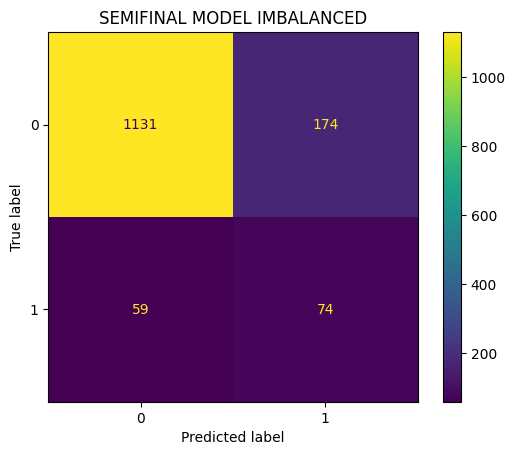

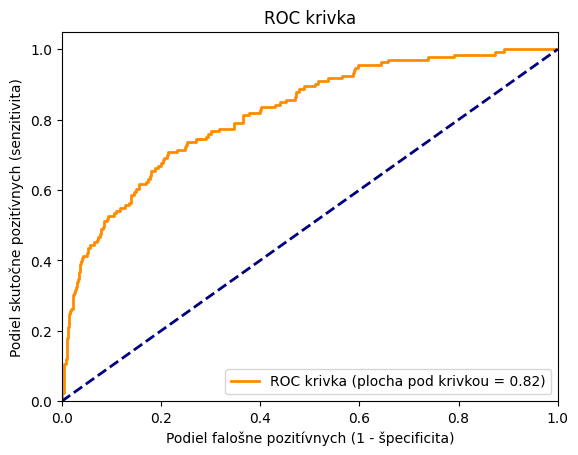

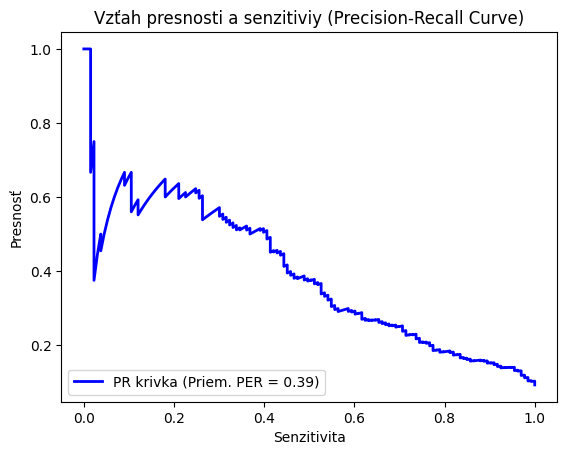

real_positives = 133.0, total = 1438
FINAL MODEL IMBALANCED Accuracy: 0.7795549374130737
FINAL MODEL IMBALANCED Precision: 0.25
FINAL MODEL IMBALANCED Recall: 0.6917293233082706
FINAL MODEL IMBALANCED Specificity: 0.7885057471264367
FINAL MODEL IMBALANCED F1 Score: 0.36726546906187624


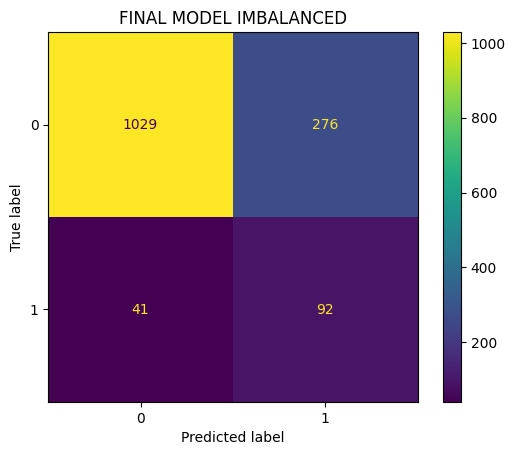

In [19]:

mlp_classifier = MLPClassifier(
    random_state=37,
    activation= 'tanh',
    alpha = 1e-05,
    hidden_layer_sizes = (5, 3),
    learning_rate = 'constant',
    max_iter = 500,
    solver = 'adam'
    )


mlp_classifier.fit(X_train_valid_balanced, y_train_valid_balanced)

eval(y_valid_valid_imbalanced, mlp_classifier.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')


y_probs = mlp_classifier.predict_proba(X_valid_valid_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych (1 - špecificita)')
plt.ylabel('Podiel skutočne pozitívnych (senzitivita)')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()


eval(y_valid_valid_imbalanced, predict_w_threshold(mlp_classifier, X_valid_valid_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

## FINAL TESTING

real_positives = 700.0, total = 1750
FINAL MODEL TRAIN BALANCED Accuracy: 0.7491428571428571
FINAL MODEL TRAIN BALANCED Precision: 0.7301587301587301
FINAL MODEL TRAIN BALANCED Recall: 0.5914285714285714
FINAL MODEL TRAIN BALANCED Specificity: 0.8542857142857143
FINAL MODEL TRAIN BALANCED F1 Score: 0.6535122336227309


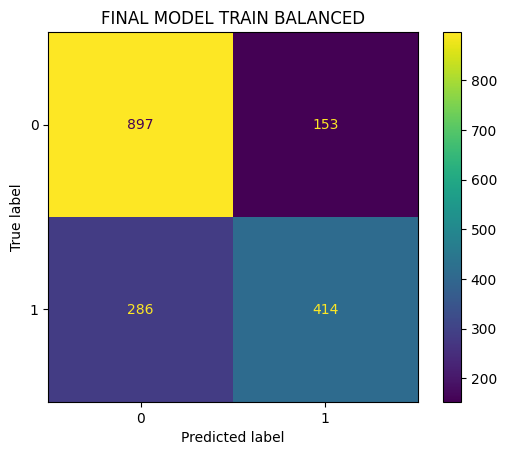

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7418604651162791
FINAL MODEL BALANCED Precision: 0.725925925925926
FINAL MODEL BALANCED Recall: 0.5697674418604651
FINAL MODEL BALANCED Specificity: 0.8565891472868217
FINAL MODEL BALANCED F1 Score: 0.6384364820846906


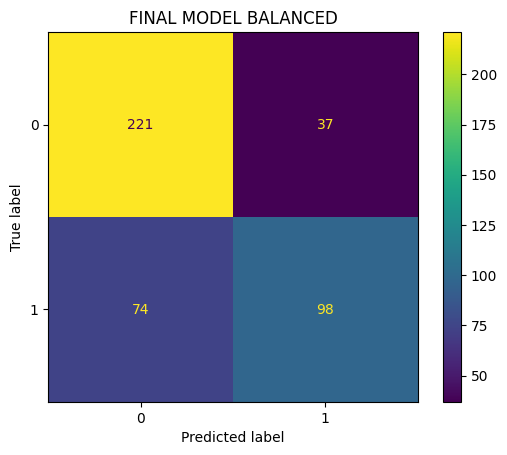

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.8230383973288815
FINAL MODEL IMBALANCED Precision: 0.28654970760233917
FINAL MODEL IMBALANCED Recall: 0.5697674418604651
FINAL MODEL IMBALANCED Specificity: 0.8498461538461538
FINAL MODEL IMBALANCED F1 Score: 0.38132295719844356


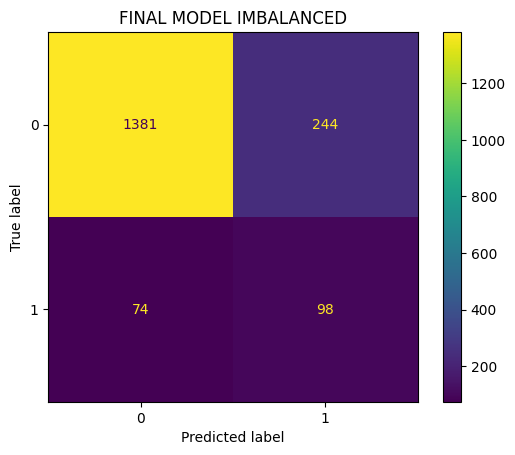

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7302325581395349
FINAL MODEL BALANCED Precision: 0.6538461538461539
FINAL MODEL BALANCED Recall: 0.6918604651162791
FINAL MODEL BALANCED Specificity: 0.7558139534883721
FINAL MODEL BALANCED F1 Score: 0.672316384180791


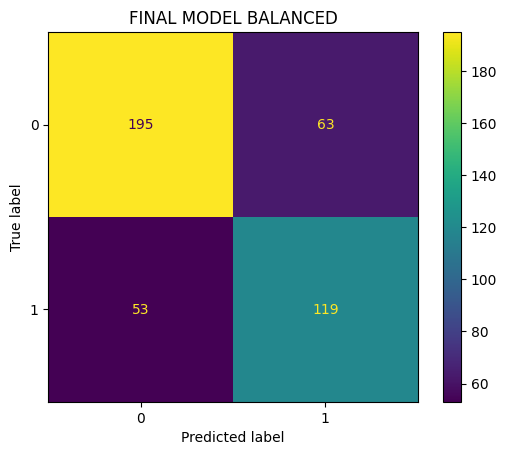

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7518085698386199
FINAL MODEL IMBALANCED Precision: 0.232421875
FINAL MODEL IMBALANCED Recall: 0.6918604651162791
FINAL MODEL IMBALANCED Specificity: 0.7581538461538462
FINAL MODEL IMBALANCED F1 Score: 0.34795321637426896


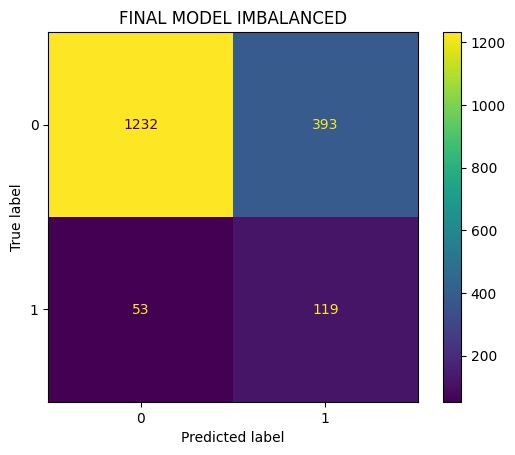

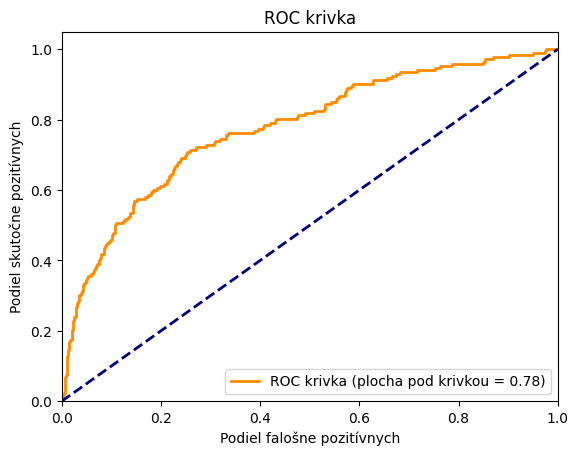

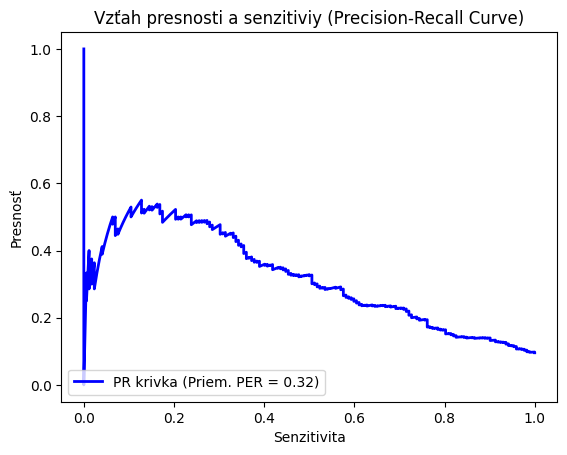

In [20]:
rf_final = MLPClassifier(
    random_state=37,
    activation= 'tanh',
    alpha = 1e-05,
    hidden_layer_sizes = (5, 3),
    learning_rate = 'constant',
    max_iter = 500,
    solver = 'adam'
    )

rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_train_balanced, rf_final.predict(X_train_balanced), 'FINAL MODEL TRAIN BALANCED')
eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

average_precision = average_precision_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

